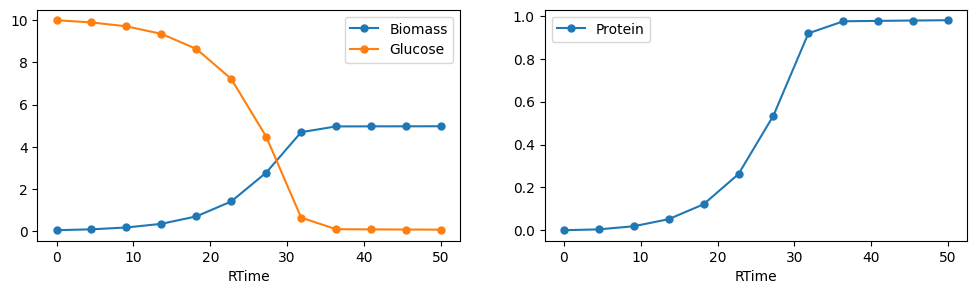

In [19]:
from typing import Union

from matplotlib import markers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from tqdm import tqdm

pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_SAMPLES = 12

# parameter values
mumax = 0.20      # 1/hour
Ks = 1.00         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.2         # g/g
Sin = 10.0         # g/liter

# inlet flowrate
def Fs(t):
    return 0.05

# reaction rates
def mu(S):
    return mumax*S/(Ks + S)

def Rg(X,S):
    return mu(S)*X
    
def Rp(X,S):
    return Ypx*Rg(X,S)

def a(t):
    return Ypx * (1 - np.exp(-Ypx*t))

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fs(t)*X/V + Rg(X,S)
    # dP = -Fs(t)*P/V + Rp(X,S)
    dP = -Fs(t)*P/V + a(t) * Rg(X, S)
    dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
    dV = Fs(t)
    return [dX,dP,dS,dV]

IC = [0.05, 0.0, 10.0, 1.0]

t = np.linspace(0,50,NUM_SAMPLES)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()

# Generate dataset 
df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V, 'Protein': P})

# Plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
df.plot(x='RTime', y=['Biomass', 'Glucose'], ax=ax[0], marker='o', markersize=5)
df.plot(x='RTime', y='Protein', ax=ax[1], marker='o', markersize=5)
plt.show()

In [20]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        t_start: Union[np.float32, torch.Tensor],
        t_end: Union[np.float32, torch.Tensor],
    ):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 64)
        self.fc1 = nn.Linear(64, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)

        # Kinetic parameters
        self.mu_max = nn.Parameter(torch.tensor([0.3]))

        # Modeling protein production
        self.c1 = nn.Parameter(torch.tensor([0.5]))
        self.c2 = nn.Parameter(torch.tensor([0.5]))
        self.c3 = nn.Parameter(torch.tensor([0.5]))
        self.c4 = nn.Parameter(torch.tensor([0.5]))
       
        self.t_start = t_start
        self.t_end = t_end
        if isinstance(self.t_start, torch.Tensor):
            self.t_start = self.t_start.item()
        if isinstance(self.t_end, torch.Tensor):
            self.t_end = self.t_end.item()

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x
    
def loss_fn(
    net: torch.nn.Module,
    scaffold: int, 
    t_start: Union[np.float32, torch.Tensor],
    t_end: Union[np.float32, torch.Tensor],
) -> torch.Tensor:

    def alpha(scaffold, t):
        if scaffold == 1: 
            return net.c1
        elif scaffold == 2:
            return net.c1 * (1 - torch.exp(-net.c2 * t))
        elif scaffold == 3:
            return net.c1 * (1 - torch.exp(-net.c2 * t**2)) + net.c3 * (1 - torch.exp(-net.c4 * t)) 
    
    if isinstance(t_start, torch.Tensor):
        t_start = t_start.item()
    if isinstance(t_end, torch.Tensor):
        t_end = t_end.item()

    t = torch.linspace(t_start, t_end, steps=100).view(-1, 1).requires_grad_(True)
    F = torch.tensor([Fs(t) for t in t], dtype=torch.float32).view(-1, 1)

    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = u_pred[:, 2].view(-1, 1)
    P_pred = u_pred[:, 3].view(-1, 1) 

    dXdt_pred = torch.autograd.grad(X_pred, t, grad_outputs=torch.ones_like(X_pred), create_graph=True)[0]
    dSdt_pred = torch.autograd.grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    dVdt_pred = torch.autograd.grad(V_pred, t, grad_outputs=torch.ones_like(V_pred), create_graph=True)[0]
    dPdt_pred = torch.autograd.grad(P_pred, t, grad_outputs=torch.ones_like(P_pred), create_graph=True)[0]

    mu = net.mu_max * S_pred / (Ks + S_pred)
    
    error_dXdt = nn.MSELoss()(
        dXdt_pred, mu * X_pred - X_pred * F / V_pred
    )
    error_dSdt = nn.MSELoss()(
        dSdt_pred, - mu * X_pred / Yxs + F / V_pred * (Sin - S_pred)
    )
    error_dVdt = nn.MSELoss()(
        dVdt_pred, F
    )
    error_dPdt = nn.MSELoss()(
        dPdt_pred, alpha(scaffold, t) * mu * X_pred - P_pred * F / V_pred
    )

    error_ode = error_dXdt + error_dSdt + error_dVdt + error_dPdt

    return error_ode


In [21]:
def main(train_df: pd.DataFrame, full_df: pd.DataFrame, scaffold: int, num_epochs: int = 10000):
    
    t_start, t_end = train_df['RTime'].min(), train_df['RTime'].max()
    t_train = numpy_to_tensor(train_df['RTime'].values)
    X_train = numpy_to_tensor(train_df['Biomass'].values)
    S_train = numpy_to_tensor(train_df["Glucose"].values)
    P_train = numpy_to_tensor(train_df["Protein"].values)
    V_train = numpy_to_tensor(train_df["V"].values)

    u_train = torch.cat((X_train, S_train, V_train, P_train), dim=1).to(DEVICE)
    net = PINN(1, 4, t_start, t_end).to(DEVICE)

    optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
    w_data, w_ode, w_ic = 1.0, 1.0, 0.25

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)

        loss_data = nn.MSELoss()(u_pred, u_train) * w_data
        loss_ode = loss_fn(net, scaffold, t_start, t_end) * w_ode
        loss_ic = nn.MSELoss()(u_pred[0, :], u_train[0, :]) * w_ic

        loss = loss_data + loss_ode + loss_ic
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Loss Data: {loss_data.item():.4f}, Loss ODE: {loss_ode.item():.4f}, Loss IC: {loss_ic.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.2f}, c1: {net.c1.item():.2f}, c2: {net.c2.item():.2f}, c3: {net.c3.item():.2f}, c4: {net.c4.item():.2f}")


    t_test = numpy_to_tensor(full_df['RTime'].values)
    u_pred = pd.DataFrame(net.forward(t_test).detach().cpu().numpy())
    u_pred.columns = ["Biomass", "Glucose", "V", "Protein"]
    u_pred['RTime'] = t_test.detach().cpu().numpy()

    return net, u_pred

In [22]:
df.shape

(12, 5)

In [23]:
# Select training data
train_df = df.iloc[:12].copy()

In [24]:
# Train the model and get results
net_A, u_pred_A = main(train_df, df, scaffold=1, num_epochs=5000)
net_B, u_pred_B = main(train_df, df, scaffold=2, num_epochs=5000)
net_C, u_pred_C = main(train_df, df, scaffold=3, num_epochs=5000)

Epoch 1/5000, Loss: 3476.3628, Loss Data: 15.3237, Loss ODE: 3454.7490, Loss IC: 6.2901
mu_max: 0.30, c1: 0.50, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 101/5000, Loss: 21.9918, Loss Data: 14.4868, Loss ODE: 1.2297, Loss IC: 6.2754
mu_max: 0.30, c1: 0.50, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 201/5000, Loss: 19.8731, Loss Data: 12.6243, Loss ODE: 1.3469, Loss IC: 5.9019
mu_max: 0.29, c1: 0.49, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 301/5000, Loss: 14.2160, Loss Data: 9.2570, Loss ODE: 0.9837, Loss IC: 3.9753
mu_max: 0.28, c1: 0.48, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 401/5000, Loss: 4.2979, Loss Data: 3.1166, Loss ODE: 0.8059, Loss IC: 0.3754
mu_max: 0.28, c1: 0.47, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 501/5000, Loss: 3.0456, Loss Data: 2.3894, Loss ODE: 0.5915, Loss IC: 0.0647
mu_max: 0.27, c1: 0.47, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 601/5000, Loss: 3.2978, Loss Data: 2.5336, Loss ODE: 0.5515, Loss IC: 0.2127
mu_max: 0.27, c1: 0.46, c2: 0.50, c3: 0.50, c4: 0.50
Epoch 701/5000, Loss: 3.0854, Loss Dat

In [28]:
# If u_pred have negatives values, make them zero
u_pred_A[u_pred_A < 0] = 0
u_pred_B[u_pred_B < 0] = 0
u_pred_C[u_pred_C < 0] = 0

In [29]:
print("Model A")
print(f'mu_max: {net_A.mu_max.item():.2f}, c1: {net_A.c1.item():.2f}')
print("Model B")
print(f'mu_max: {net_B.mu_max.item():.2f}, c1: {net_B.c1.item():.2f}, c2: {net_B.c2.item():.2f}')
print("Model C")
print(f'mu_max: {net_C.mu_max.item():.2f}, c1: {net_C.c1.item():.2f}, c2: {net_C.c2.item():.2f}, c3: {net_C.c3.item():.2f}, c4: {net_C.c4.item():.2f}')

Model A
mu_max: 0.20, c1: 0.34
Model B
mu_max: 0.14, c1: 0.31, c2: 0.34
Model C
mu_max: 0.21, c1: 0.32, c2: 0.49, c3: 0.32, c4: 0.34


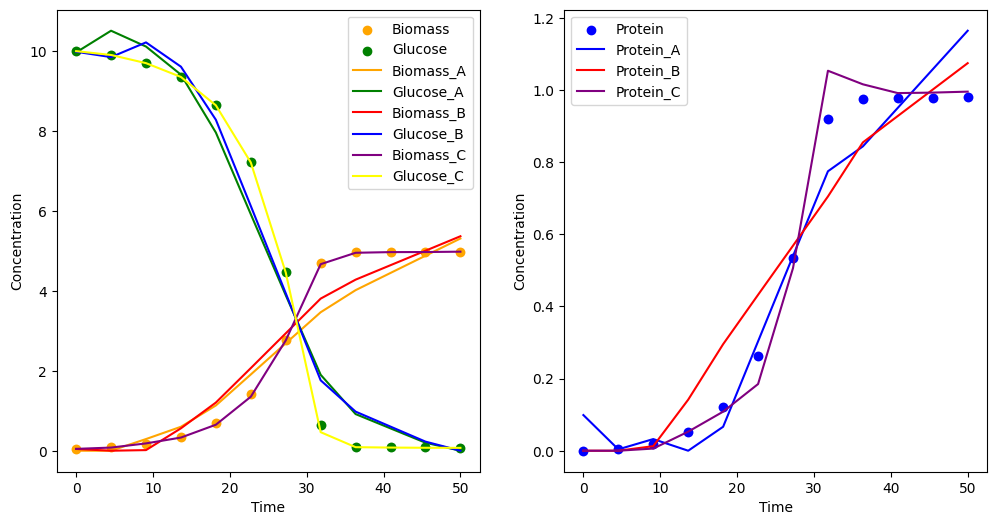

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(df['RTime'], df['Biomass'], color='orange', label="_Biomass", alpha=0.3)
ax[0].scatter(df['RTime'], df['Glucose'], color='green', label="_Glucose", alpha=0.3)
ax[0].scatter(train_df['RTime'], train_df['Biomass'], color='orange', label='Biomass', alpha=1.0)
ax[0].scatter(train_df['RTime'], train_df['Glucose'], color='green', label='Glucose', alpha=1.0)
ax[1].scatter(df['RTime'], df['Protein'], color='blue', label='_Protein', alpha=0.3)   
ax[1].scatter(train_df['RTime'], train_df['Protein'], color='blue', label='Protein', alpha=1.0)

ax[0].plot(u_pred_A['RTime'], u_pred_A['Biomass'], color='orange', label='Biomass_A')
ax[0].plot(u_pred_A['RTime'], u_pred_A['Glucose'], color='green', label='Glucose_A')
ax[0].plot(u_pred_B['RTime'], u_pred_B['Biomass'], color='red', label='Biomass_B')
ax[0].plot(u_pred_B['RTime'], u_pred_B['Glucose'], color='blue', label='Glucose_B')
ax[0].plot(u_pred_C['RTime'], u_pred_C['Biomass'], color='purple', label='Biomass_C')
ax[0].plot(u_pred_C['RTime'], u_pred_C['Glucose'], color='yellow', label='Glucose_C')
ax[1].plot(u_pred_A['RTime'], u_pred_A['Protein'], color='blue', label='Protein_A')
ax[1].plot(u_pred_B['RTime'], u_pred_B['Protein'], color='red', label='Protein_B')
ax[1].plot(u_pred_C['RTime'], u_pred_C['Protein'], color='purple', label='Protein_C')

ax[0].legend()
ax[1].legend()

 ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')

plt.show()